# Pre-processing and Feature engineering

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# Loading Dataset (the original dataset from kaggle with our additional manually-collected features)
df = pd.read_csv(r"Data/Original_data_with_additional_features.csv")
print("Done loading original data file from CSV file:")
df

Done loading original data file from CSV file:


,p_1_gender,p_1_age,p_1_fast_round_sum,p_1_play_sum_chosen,p_1_round_status,p_2_gender,p_2_age,p_2_fast_round_sum,p_2_play_sum_chosen,p_2_round_status,...,p_2_low,p_2_neutral,p_3_high,p_3_middle,p_3_low,p_3_neutral,p_4_high,p_4_middle,p_4_low,p_4_neutral
0,male,30,20000,20000,1,female,27,50000,50000,1,...,0,0,1,2,0,0,0,2,1.0,0
1,male,45,35000,35000,1,female,67,30000,30000,0,...,0,1,0,2,0,0,1,1,0.0,0
2,female,33,25000,25000,1,male,57,20000,20000,1,...,0,1,-1,-1,-1,-1,-1,-1,-1.0,-1
3,male,34,35000,35000,1,female,29,30000,30000,1,...,0,0,3,0,0,0,-1,-1,-1.0,-1
4,male,50,30000,90000,0,female,38,35000,35000,1,...,0,2,0,1,0,1,0,2,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,female,26,15000,15000,0,female,23,20000,20000,1,...,0,0,1,1,0,0,0,2,0.0,0
97,male,24,20000,20000,1,female,45,30000,140000,0,...,0,0,0,2,0,0,1,1,1.0,0
98,female,54,20000,20000,1,male,33,20000,120000,0,...,0,0,0,2,0,0,1,1,0.0,0
99,female,31,40000,40000,0,female,29,45000,45000,0,...,0,0,1,0,0,0,0,1,0.0,0


In [33]:
prepped_df = pd.DataFrame()

for i in range(1, 5):
    player_columns = ['sex','sex_binary','age','age_group', 'player_number','first_player','second_player','third_player', 'fourth_player', 'encouragement_low', 'encouragement_middle', 'encouragement_high', 'encouragement_neutral','fast_round_sum', 'success_group', 'amount_chosen','risk', 'did_win']
    player_df = pd.DataFrame(columns=player_columns)
    original_columns = [f'p_{i}_gender', f'p_{i}_age', f'p_{i}_fast_round_sum', f'p_{i}_play_sum_chosen',
                      f'p_{i}_round_status', f'p_{i}_low', f'p_{i}_middle', f'p_{i}_high', f'p_{i}_neutral']
    player_data = df[original_columns]

    # Existing features from original data:
    player_df['sex'] = player_data[f'p_{i}_gender']
    player_df['age'] = player_data[f'p_{i}_age']
    player_df['fast_round_sum'] = player_data[f'p_{i}_fast_round_sum']
    player_df['amount_chosen'] = player_data[f'p_{i}_play_sum_chosen']
    player_df['player_number'] = i
    player_df['did_win'] = player_data[f'p_{i}_round_status']

    # Add encouragement (manually-collected) features:
    player_df['encouragement_low'] = player_data[f'p_{i}_low']
    player_df['encouragement_middle'] = player_data[f'p_{i}_middle']
    player_df['encouragement_high'] = player_data[f'p_{i}_high']
    player_df['encouragement_neutral'] = player_data[f'p_{i}_neutral']
    for label in ["encouragement_low","encouragement_middle","encouragement_high","encouragement_neutral"]:
        player_df[label].fillna(value=0, inplace=True)

    # Add indicators for player number:
    player_df['first_player'] = 1 if i == 1 else 0
    player_df['second_player'] = 1 if i == 2 else 0
    player_df['third_player'] = 1 if i == 3 else 0
    player_df['fourth_player'] = 1 if i == 4 else 0

    # Add categorical features (updated later on):
    player_df['risk'] = 2  # risk (3=High, 2=Medium, 1=Low)
    player_df.loc[(player_df['fast_round_sum'] < player_df['amount_chosen']), 'risk'] = 3
    player_df.loc[(player_df['fast_round_sum'] > player_df['amount_chosen']), 'risk'] = 1
    #
    # gender (1=woman, 0=man) although IRL gender is not binary
    player_df.loc[(player_df['sex'] == "female"), 'sex_binary'] = 1
    player_df.loc[(player_df['sex'] == "male"), 'sex_binary'] = 0

    # age group (20= 20 or less, 30 = 30-40, 40 = 40-50, 50 = 50 or more):
    player_df['age_group'] = 20
    player_df.loc[((player_df['age'] >= 30) & (player_df['age'] < 40)), 'age_group'] = 30
    player_df.loc[((player_df['age'] >= 40) & (player_df['age'] < 50)), 'age_group'] = 40
    player_df.loc[(player_df['age'] >= 50), 'age_group'] = 50

    # success group (string that represent range of amount in ILS):
    player_df['success_group'] = "0-15"
    for j in range(1, 6):
        lower, higher, label = int(f"{j}5000"), int(f"{j + 1}5000"), f"{j}5-{j + 1}5"
        player_df.loc[(player_df['fast_round_sum'] >= lower) & (player_df['fast_round_sum'] < higher), 'success_group'] = label
    prepped_df = pd.concat((prepped_df, player_df), axis="index")  # Add player_df to general prepped_df

print("Done preprocessing.\nThe preprocessed dataframe is now formatted such that each row represents one player:")
prepped_df

Done preprocessing.
The preprocessed dataframe is now formatted such that each row represents one player:


,sex,sex_binary,age,age_group,player_number,first_player,second_player,third_player,fourth_player,encouragement_low,encouragement_middle,encouragement_high,encouragement_neutral,fast_round_sum,success_group,amount_chosen,risk,did_win
0,male,0,30,30,1,1,0,0,0,0.0,3,0,0,20000,15-25,20000,2,1
1,male,0,45,40,1,1,0,0,0,0.0,1,2,0,35000,35-45,35000,2,1
2,female,1,33,30,1,1,0,0,0,0.0,0,3,0,25000,25-35,25000,2,1
3,male,0,34,30,1,1,0,0,0,0.0,2,1,0,35000,35-45,35000,2,1
4,male,0,50,50,1,1,0,0,0,0.0,2,1,0,30000,25-35,90000,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,male,0,29,20,4,0,0,0,1,0.0,2,0,0,40000,35-45,40000,2,1
97,female,1,55,50,4,0,0,0,1,1.0,1,1,0,40000,35-45,180000,3,1
98,male,0,57,50,4,0,0,0,1,0.0,1,1,0,30000,25-35,30000,2,1
99,male,0,33,30,4,0,0,0,1,0.0,1,0,0,30000,25-35,125000,3,1


# Data Analysis

In [34]:
sex_colors = ['deeppink','dodgerblue']
age_colors = ['deepskyblue','royalblue','mediumblue','midnightblue']
success_colors = ['voilet','hotpink','mediumvioletred','mediumpurple','blueviolet','indigo']
risk_colors = ['crimson','gold','limegreen']

## General Demography of players
#### Sex demography
The game's participants are split equally between the sexes (each group in the game consists of 2 females and 2 male).

In [35]:
sex_df = prepped_df[['sex', 'sex_binary', 'age']].groupby('sex').count().reset_index()
fig = px.pie(sex_df, values='sex_binary', names='sex',color='sex',color_discrete_sequence=sex_colors, title='Sex Distribution')
fig.show()

#### Age demography
The population of the participants is gennerally young - 29.5%  are under 30 years old, and 72.1% is under 40 years old.

In [36]:
age_df = prepped_df[['age', 'age_group']].groupby('age_group').count().reset_index()
age_df = age_df.sort_values(by=['age_group'])
fig = px.pie(age_df, values='age', names='age_group',color='age_group',color_discrete_sequence=age_colors, title='Age Distribution')
fig.show()


#### First round success demography

In [37]:
success_df = prepped_df[['age', 'success_group']].groupby('success_group').count().reset_index()
success_df = success_df.sort_values(by=['success_group'])
fig = px.pie(success_df, values='age', names='success_group',
             title='First Round Success (in thousands of ILS) Distribution')
fig.show()

## Risk Taking Analysis
### Demography effect on risk
#### Risk taking - general (no segmentation)

In [38]:
general_risk_df = prepped_df[['sex', 'risk']].groupby('risk').count().reset_index()
general_risk_df = general_risk_df.rename({'sex': 'count'}, axis=1)
fig = px.pie(general_risk_df, values='count', names='risk', title='Risk - General Distribution')
fig.show()


#### Risk taking by gender

In [39]:
gender_risk_df = prepped_df[['sex', 'sex_binary', 'age', 'risk']].groupby(
    ['risk', 'sex']).count().reset_index()
female_list = [gender_risk_df.at[0, 'age'], gender_risk_df.at[2, 'age'], gender_risk_df.at[4, 'age']]
male_list = [gender_risk_df.at[1, 'age'], gender_risk_df.at[3, 'age'], gender_risk_df.at[5, 'age']]
fig = go.Figure(data=[
    go.Bar(name='Men', x=['Low Risk', 'Medium Risk', 'High Risk'], y=male_list, marker_color=sex_colors[1]),
    go.Bar(name='Women', x=['Low Risk', 'Medium Risk', 'High Risk'], y=female_list, marker_color=sex_colors[0])])
fig.update_layout(barmode='group')  # Change the bar mode
fig.show()

#### Risk taking by age (percentages out of participants in the same age group)

In [40]:
age_risk_df = prepped_df[['sex', 'age_group', 'risk']].groupby(['risk', 'age_group']).count().reset_index()
age_perc = [10, 100 / 282, 100 / 112]
list20 = [0 * age_perc[0], age_risk_df.at[3, 'sex'] * age_perc[1], age_risk_df.at[7, 'sex'] * age_perc[2]]
list30 = [age_risk_df.at[0, 'sex'] * age_perc[0], age_risk_df.at[4, 'sex'] * age_perc[1],
          age_risk_df.at[8, 'sex'] * age_perc[2]]
list40 = [age_risk_df.at[1, 'sex'] * age_perc[0], age_risk_df.at[5, 'sex'] * age_perc[1],
          age_risk_df.at[9, 'sex'] * age_perc[2]]
list50 = [age_risk_df.at[2, 'sex'] * age_perc[0], age_risk_df.at[6, 'sex'] * age_perc[1],
          age_risk_df.at[10, 'sex'] * age_perc[2]]
fig = go.Figure(data=[
    go.Bar(name='10-30', x=['Low Risk', 'Medium Risk', 'High Risk'], y=list20,marker_color=age_colors[0]),
    go.Bar(name='30-40', x=['Low Risk', 'Medium Risk', 'High Risk'], y=list30,marker_color=age_colors[1]),
    go.Bar(name='40-50', x=['Low Risk', 'Medium Risk', 'High Risk'], y=list40,marker_color=age_colors[2]),
    go.Bar(name='50+', x=['Low Risk', 'Medium Risk', 'High Risk'], y=list50,marker_color=age_colors[3])])
fig.update_layout(barmode='group')
fig.update_layout(title="Age by risk taking (percents out of participants in the same age group)")
fig.show()

##### Age by risk taking (percentages out of participants in the same risk group)

In [41]:
risk_perc = [100 / 119, 100 / 172, 100 / 54, 100 / 59]
low_list = [0 * risk_perc[0], age_risk_df.at[0, 'sex'] * risk_perc[1], age_risk_df.at[1, 'sex'] * risk_perc[2],
            age_risk_df.at[2, 'sex'] * risk_perc[3]]
medium_list = [age_risk_df.at[3, 'sex'] * risk_perc[0], age_risk_df.at[4, 'sex'] * risk_perc[1],
               age_risk_df.at[5, 'sex'] * risk_perc[2], age_risk_df.at[6, 'sex'] * risk_perc[3]]
high_list = [age_risk_df.at[7, 'sex'] * risk_perc[0], age_risk_df.at[8, 'sex'] * risk_perc[1],
             age_risk_df.at[9, 'sex'] * risk_perc[2], age_risk_df.at[10, 'sex'] * risk_perc[3]]
fig = go.Figure(data=[
    go.Bar(name='Low Risk', x=['10-30', '30-40', '40-50', '50+'], y=low_list,marker_color=risk_colors[0]),
    go.Bar(name='Medium Risk', x=['10-30', '30-40', '40-50', '50+'], y=medium_list,marker_color=risk_colors[1]),
    go.Bar(name='High Risk', x=['10-30', '30-40', '40-50', '50+'], y=high_list,marker_color=risk_colors[2])])
fig.update_layout(barmode='group')  # Change the bar mode
fig.update_layout(title="Risk taking by age (percents)")
fig.show()

### Correlation between first round success and risk taking
#### add title here

<ipython-input-42-eaacac437af3>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-42-eaacac437af3>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



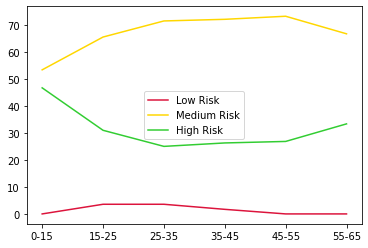

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

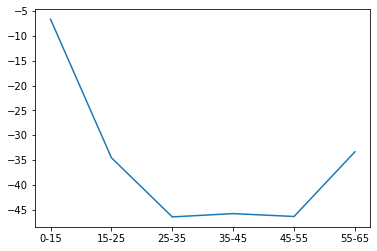

In [42]:
success_df = prepped_df[['sex', 'success_group', 'risk']].groupby(['risk', 'success_group']).count().reset_index()
succ_perc = [100 / 15, 100 / 84, 100 / 140, 100 / 118, 100 / 41, 100 / 6]
labels = ['0-15', '15-25', '25-35', '35-45', '45-55', '55-65']

success_df['percent'] = 0
for i in range(6):
    success_df['percent'][success_df['success_group'] == labels[i]] = success_df['sex'] * succ_perc[i]

ax = plt.subplots()[1]
low_list = success_df[success_df['risk'] == 1]['percent'].to_list()
low_list = [0, low_list[0], low_list[1], low_list[2], 0, 0]
medium_list = success_df[success_df['risk'] == 2]['percent'].to_list()
high_list = success_df[success_df['risk'] == 3]['percent'].to_list()
age_groups = ['0-15', '15-25', '25-35', '35-45', '45-55', '55-65']

fig = go.Figure(data=[
    go.Bar(name='Low Risk', x=age_groups, y=low_list,marker_color=risk_colors[0]),
    go.Bar(name='Medium Risk', x=age_groups, y=medium_list,marker_color=risk_colors[1]),
    go.Bar(name='High Risk', x=age_groups, y=high_list,marker_color=risk_colors[2])])
fig.update_layout(barmode='group')
fig.update_layout(title="Risk taking by first round success (percents)")
fig.show()

plt.plot(labels, low_list, label='Low Risk', color=risk_colors[0])
plt.plot(labels, medium_list, label='Medium Risk', color=risk_colors[1])
plt.plot(labels, high_list, label='High Risk', color=risk_colors[2])
plt.legend()
plt.show()

d = {'success_group': age_groups, 'dist': [0] * len(age_groups)}
dist_df = pd.DataFrame(data=d)

for i, group in enumerate(age_groups):
    medium_index, high_index = 3 + i, 9 + i
    dist = success_df.at[high_index, 'percent'] - success_df.at[medium_index, 'percent']
    dist_df.loc[i, 'dist'] = dist

plt.plot(dist_df['success_group'], dist_df['dist'])
plt.plot